# Quench Spectral function

Here we consider a novel way to obtain the spectral properties of the physical system following https://arxiv.org/pdf/1910.02839 and https://scipost.org/SciPostPhys.14.6.151. 

- Typically, we can obtain the spectral properties of the physical systems through the **double Fourier transformation** of the **unequal-time correlators** (UTC) from an **equilibrium state**, known as the spectral function or the dynamical structure factor. This is closely related to the pump-probe spectroscopic techniques in the experiements.

- The newly introduced approach extracts the similar information from  the **double Fourier transformation** of the **equal-time correlators** (ETC) from a **non-equilibirum state**.


---

#### Why should we be interested in this?

- Possible advantage (i) : we don't need to prepare the ground state. Instead, we prepare a state that has finite overlap with ground state and the interesting excited states. The latter is often easier.

- Possible advantage (ii) :  (conjecture) the protocal is hard to simulate classically. This is a global quench. The non-equbilibirum state has finite energy density. The entanglement entropy is expected to grow linearly with time and hence hard to simulate using conventional tensor network techniques.

- Questions: Could we also get nice result? Is the signal strong?


## Method
----

In general the unequal-time correlators are given as

<img src="./img/1.png" width="500" /> 

and the euqal-time correlators are given as

<img src="./img/2.png" width="400" />.


By inserting the complete basis using the Hamiltonian eignestates, the double Fourier transformation of the ETC has the form

<img src="./img/3.png" width="500" />.



----

Now suppose the non-equilibrium state we consider is a pure state that has large overlap with the ground state, i.e.,

<img src="./img/4.png" width="500" />.


One example is 
$$
| \psi \rangle = (1 - \epsilon) | 0 \rangle + \sum_{n\neq0} \epsilon_n |n\rangle, \qquad \epsilon_n << 1
$$

Then the above Fourier transformation of the ETC can be expanded to 

<img src="./img/5.png" width="700" />,

where the first term is just a delta peak at $\omega=0$ and the last term gives the non-trivial contribution for positive frequency.

Starting from the ground state $|0\rangle$, we see the intermediate state $| m \rangle $ has momentum $P_m = k$.
The second excitated state $| n \rangle $ has zero momentum.
This indicates that the excitation bringing $| m \rangle$ to $| n \rangle$ must have opposite momentum $-k$, i.e., $|n\rangle = \hat{b}^\dagger_{-k}\hat{b}^\dagger_{k}|0\rangle$ with energy $E_n = 2E_k$.

By this arugment we expect to obtain,

<img src="./img/6.png" width="300" />

where the spectral weight $F(k)$ depends on the operators $\hat{O}_1$ and $\hat{O}_2$.
Based on this expression, we expect that we can also probe the excitation spectrum through the Fourier transformation of the ETC from a non-equilbrium state.

------

## Example: Transverse field Ising model

An example is given by https://scipost.org/SciPostPhys.14.6.151 using Gaussian simulation. Aside from the contraint in the ansatz, the work exactly follows the protocal above to compute the quench spectral function.

The Hamiltonian is given as
$$
H = - \sum_{\langle i, j \rangle} X_i X_j - \sum_i g Z_i
$$

Starting from infinite field ground state $g\rightarrow\infty$, they consider the quench to finite $g$ at the paramagnetic phase, i.e., not crossing the phase transition, and show that the can obtain the spectral function correctly.


<img src="./img/QSF.png" width="700" />


### Below we try to reproduce the same result.

In [1]:
from example import *
import ft
import matplotlib.pyplot as plt
plt.style.use('physrev.mplstyle')

(8192, 8192) H_TFI X term for i=121
solving H1
E =  [-13. -11. -11.  11.  11.  13.]
solving H_TFI
init vec =  [0.01104854 0.01104854 0.01104854 ... 0.01104854 0.01104854 0.01104854]
E_TFI =  [-27.65218934 -25.65211998 -25.23702089  25.53915102  25.53915102
  27.65211998]
overlap with eigenstates=  [8.96110082e-01 1.02695630e-15 9.92261828e-16 1.68988279e-17
 2.69881206e-16 1.37126333e-15]


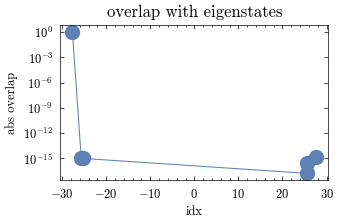

evolving and getting ETC and UTC


In [2]:
L = 13
g = 2.

# Out TFI convention here is ZZ + g X
# H1 is a Hamiltonian with infinite g -> H = \sum X_i
H1 = H_x(L)
H_TFI = TFI(L, g)
print(H1.shape)

print("solving H1")
# E, V = np.linalg.eigh(H1)
E, V = scipy.sparse.linalg.eigsh(H1)
print("E = ", E)
E_min_arg = np.argmin(E)
GS = V[:, E_min_arg]
init_vec = GS.copy()
# init_vec is just a state with all equal coefficients.

###################################
### Adiabatic State Preparation ###
###################################
# total_steps = 100
# for step in range(total_steps):
#     H = (total_steps - step) / total_steps * H1 + step / total_steps * H_TFI
#     vec = scipy.sparse.linalg.expm_multiply(-1.j * H, vec)

### We don't use the adiabatic state preparation here.
### Instead we directly take the init_vec as the initial state.
### We also provide some other possibility for initialization.

print("solving H_TFI")
# E, V = np.linalg.eigh(H_TFI)
E, V = scipy.sparse.linalg.eigsh(H_TFI)
E_min_arg = np.argmin(E)
GS = V[:, E_min_arg]

sum_all_basis = np.sum(V, axis=-1)
sum_all_basis /= np.linalg.norm(sum_all_basis)


### Setup following the work SciPostPhys.14.6.151
vec = init_vec

### Other setup that one can try
# Option 1: ensuring that we have overlap with all eigenstates.
# vec = GS + 0.1 * sum_all_basis

# Option 2: forcing that we are closer to the GS
# vec = GS + 0.1 * init_vec

# Option 3: random state
# vec = np.random.rand(2**L) - 0.5


vec /= np.linalg.norm(vec)

print("init vec = ", vec)
print("E_TFI = ", E)
overlap = np.abs(vec.dot(V))
print("overlap with eigenstates= ", overlap)
plt.semilogy(E, overlap, 'o-')
plt.title('overlap with eigenstates')
plt.xlabel('idx')
plt.ylabel('abs overlap')
plt.show()

dt = 0.02
steps = 150
Op1 = Op2 = dense_Z
print("evolving and getting ETC and UTC")
ETC = get_ETC(vec, H_TFI, dt, steps, Op1, Op2, L)
UTC = get_UTC(vec, H_TFI, dt, steps, Op1, Op2, L)



Compute Fourier transform
finished
Compute Fourier transform
finished


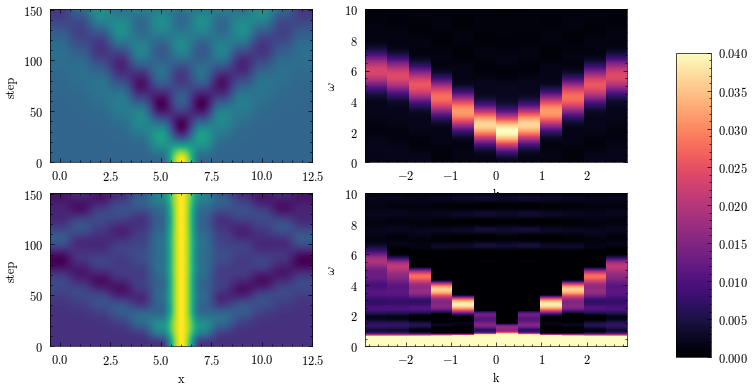

In [18]:

fig, axes = plt.subplots(2, 2, figsize=(7, 4.35))
for data_idx, data in enumerate([UTC, ETC]):
    ax = axes[data_idx][0]
    ax.imshow(data.real, origin='lower', aspect='auto')
    ax.set_xlabel('x')
    ax.set_ylabel('step')

    Swk_c, momenta_c, freqs_c = ft.get_spectral_function2(data[:, :], dt)
    ax = axes[data_idx][1]
    
    norm = None
    if data_idx == 1:
        # vmin, vmax = 0.0, 30.
        vmin, vmax = 0.0, 0.04
        import matplotlib
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        freqs_c /= 2.
    
    im = ax.pcolormesh(momenta_c, freqs_c, np.real(Swk_c[:-1, :-1]), norm=norm, cmap=plt.get_cmap('magma'))
    ax.set_xlabel('k')
    ax.set_ylabel(r'$\omega$')
    y_lim = [0, 10]
    ax.set_ylim(y_lim)

cbar_ax = fig.add_axes([1.02, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()